# import necessary packages

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stochasticTurbulenceTools_mod import stochasticTurbulence
from FFarmCaseCreation import FFarmCaseCreation, WriteFFarmFile

plt.rc("font",family="serif")
plt.rc("font",size=14)

%matplotlib inline

# Read in all known/given parameters

In [2]:
ParamsFile = 'SampleFiles/FFarmParams.txt'

In [3]:
Pars=pd.read_csv(ParamsFile, delimiter='\t',header=None,skiprows=1,index_col=0,nrows=5,names=['Var','Val'])
xlocs_tmp=pd.read_csv(ParamsFile, delimiter='\t',header=None,skiprows=6,index_col=0,nrows=1)
ylocs_tmp=pd.read_csv(ParamsFile, delimiter='\t',header=None,skiprows=7,index_col=0,nrows=1)
zlocs_tmp=pd.read_csv(ParamsFile, delimiter='\t',header=None,skiprows=8,index_col=0,nrows=1)

In [4]:
xlocs=[xlocs_tmp[1][0], xlocs_tmp[2][0], xlocs_tmp[3][0], xlocs_tmp[4][0], xlocs_tmp[5][0]]
ylocs=[ylocs_tmp[1][0], ylocs_tmp[2][0], ylocs_tmp[3][0], ylocs_tmp[4][0], ylocs_tmp[5][0]]
zlocs=[zlocs_tmp[1][0], zlocs_tmp[2][0], zlocs_tmp[3][0], zlocs_tmp[4][0], zlocs_tmp[5][0]]

In [5]:
D=Pars['Val']['D']
HubHt=Pars['Val']['HubHt']
high_extent_X=Pars['Val']['high_extent_X']
high_extent_Y=Pars['Val']['high_extent_Y']
nTurbs=int(Pars['Val']['nTurbs'])

In [6]:
Case = FFarmCaseCreation(nTurbs,'TestCase')
tpath = '../turbineModel/Test18' ## do not include .fst extention
Case.Turb(D,HubHt,tpath,cmax=3)

## Read in TurbSim Parameters

### Determine if TurbSim parameters are to be read directly from .inp or .bts file or entered manually

In [7]:
## If ReadTS=True, TurbSim parameters will be read directly from the TurbSim.inp or TurbSim.bts file
ReadTS = True

## if ReadINP = True, TurbSim parameters will be read directly from the TurbSim.inp file. Otherwise, TurbSim.bts file will be used.
ReadINP = False

In [8]:
if ReadTS == True:
    TSpath = 'SampleFiles/'
    if ReadINP == True:
        TSFile = os.path.join(TSpath+os.sep+Case.prefix+'.inp')
        
        
    else:
        TSFile = os.path.join(TSpath+os.sep+Case.prefix+'.bts')
        IFdata = stochasticTurbulence(Case.D,prefix=Case.prefix)
        IFdata.readBTS(TSpath, HubHt)
        
        IFdata.kHub = IFdata.z2k(HubHt)
        
        Vhub = IFdata.u[:,IFdata.jHub,IFdata.kHub].mean()
else:
    print('TurbSim parameters must be entered directly')

Opening file SampleFiles/TestCase.bts...


## Compute all additional input parameters

In [9]:
Case.turbLocs(xlocs,ylocs,zlocs)
Case.discretization(Vhub)
Case.highResDomain(IFdata,Vhub,Case.dX_High_desired,high_extent_X,high_extent_Y)
Case.lowResDomain(Case.dX_Low_desired,Vhub)

# Rewrite FFarm Input File

In [10]:
FFpath = 'SampleFiles/'
OrigFile = os.path.join(FFpath+Case.prefix+'.fstf')
NewFile = os.path.join(FFpath+Case.prefix+'_mod.fstf')
WriteFFarmFile(OrigFile, NewFile, Case, NewFile=False)

Modifying SampleFiles/TestCase.fstf to be SampleFiles/TestCase_mod.fstf


# visualize it

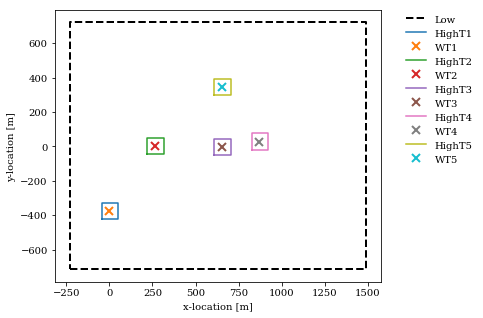

In [11]:
fig = plt.figure(figsize=(7.5,5))
ax  = fig.add_subplot(111,aspect="equal")

xmax_low = Case.X0_Low+Case.dX_Low*Case.nX_Low
ymax_low = Case.Y0_Low+Case.dY_Low*Case.nY_Low

# low-res box
ax.plot([Case.X0_Low,xmax_low,xmax_low,Case.X0_Low,Case.X0_Low],
        [Case.Y0_Low,Case.Y0_Low,ymax_low,ymax_low,Case.Y0_Low],'--k',lw=2,label='Low')

# high-res boxes
for wt in range(Case.nTurbs):
    xmax_high = Case.X0_High[wt]+Case.dX_High*Case.nX_High
    ymax_high = Case.Y0_High[wt]+Case.dY_High*Case.nY_High
    ax.plot([Case.X0_High[wt],xmax_high,xmax_high,Case.X0_High[wt],Case.X0_High[wt]],
            [Case.Y0_High[wt],Case.Y0_High[wt],ymax_high,ymax_high,Case.Y0_High[wt]],
            '-',
            label="HighT{0}".format(wt+1))
    ax.plot(Case.x[wt],Case.y[wt],'x',ms=8,mew=2,label="WT{0}".format(wt+1))

plt.legend(bbox_to_anchor=(1.05,1.015),frameon=False)

ax.set_xlabel("x-location [m]")
ax.set_ylabel("y-location [m]")

fig.tight_layout
fig.savefig('FFarmLayout.pdf',bbox_to_inches='tight',dpi=500)